![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/legal-nlp/01.Page_Splitting.ipynb)

#🎬 Installation

In [ ]:
! pip install -q johnsnowlabs

##🔗 Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, legal

# nlp.install(force_browser=True)

##🔗 Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

- Install it

In [ ]:
nlp.install()

#📌 Starting

In [ ]:
spark = nlp.start()

👌 Detected license file /content/4.3.0.spark_nlp_for_healthcare-2.json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.3.0, 💊Spark-Healthcare==4.3.0, running on ⚡ PySpark==3.1.2


#🔎 Legal Text Splitting

📚Text splitting is very important for many reasons.

- Legal documents may be **very long** (contracts, agreements, etc) and applying AI to the whole document may take much time.
- Most Language Models have **token restrictions**. For example, Bert-based models can only process up to 512 tokens, while our biggest LM (Longformers) can process up to 4096 (but affecting negatively to the performance).
- If you have models which do specific extractions on **specific sections**, it does not make sense you run them over the whole document: you may get a lot of False Positives.

But also:
- Language Models will only "understand" only that **portion of text you send to them**. If you send *little information*, they may be biased and take wrong decisions.
- On the other hand, sometimes sending *too much information* makes the information get deluded or add noise.

And!
- Make sure the tokenization and splitting mechanism is the same in training and inference, or you will get undesirable results.

Because of these reasons, the very first thing you need to think about is how to properly split your texts, depending on the kind of task you want to carry out.




#📌 1. Text Classification

#✔️ 1.1. Background
Text classification is the NLP task in charge of retrieving a `category` based on a piece of text you send to the model. A good example of it it's `Clause identification` in legal contracts.

There are several ways we can carry out Text Classification:

- `At a whole-text level (no splitting)`: That's not feasible for most legal documents. As we already know, we have token restrictions (512 for most BERT-based thansformers). We can use Longformers (4096), but in most cases, documents as Legal Agreements have much more than that, what will go for sure beyond any limitation.

- `Retrieving first page`: In most cases, the relevant information of a document is in the first page. Just by splitting by pages and retrieving the first one, you can do text classification. 

- `Using Legal NLP TextSplitter`: `TextSplitter` is an NLP annotator that it's meant to split documents into sentences, but is pretty customisable to retrieve **paragraphs or setions** as well.

- `At paragraph, section or sentence level using NER` for detecting headers and `ChunkSentenceSplitter`

The way you split may totally change the results you are getting. Let's see an example.

#✔️ 1.2. Page splitting

Sometimes, pages have patterns which tell you how to split them. In our case, `the page number` was present in the bottom of our documents.

Feel free to always analyze for signals when trying to detect pages boundaries. Patterns you can usually find in the bottom of a page:
- Bottom placeholders
- Name of people
- Name of the document
- etc.

In [ ]:
document_assembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

text_splitter = legal.TextSplitter() \
    .setInputCols(["document"]) \
    .setOutputCol("pages")\
    .setCustomBounds(["\n+\s*[0-9]+\s*\n+"])\
    .setUseCustomBoundsOnly(True)\
    .setExplodeSentences(True)

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    text_splitter])

📜Explanation:
- `.setCustomBounds(["\n+\s+[0-9]\n+"])` sets an array of regular expression(s) to tell the annotator how to split the document.
- `.setUseCustomBoundsOnly(True)` the default behaviour of TextSplitter is Text Splitting, so we set to ignore the default regex ('\n', ...).
- `.setExplodeSentences(True)` creates one new row in the dataframe per split.


Let's download a document and use `whole-text` classifiers.

In [ ]:
import requests
URL = "https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/legal-nlp/data/credit_agreement.txt"
response = requests.get(URL)

credit_agreement = response.content.decode('utf-8')

Let's apply our page splitter.

## Using Fit/Transform (all the dataframe will be processed in paralel using all the spark cluster nodes)

In [ ]:
#fit: trains, configures and prepares the pipeline for inference. 

sdf = spark.createDataFrame([[ credit_agreement ]]).toDF("text")

fit = nlp_pipeline.fit(sdf)

In [ ]:
%%time

#transforms: executes inference on a fit pipeline
res = fit.transform(sdf)

res.select('pages').show()

+--------------------+
|               pages|
+--------------------+
|[{document, 70, 3...|
|[{document, 31821...|
|[{document, 34560...|
|[{document, 37458...|
|[{document, 40734...|
|[{document, 43945...|
|[{document, 46511...|
|[{document, 49420...|
|[{document, 53065...|
|[{document, 56539...|
|[{document, 59694...|
|[{document, 62708...|
|[{document, 65372...|
|[{document, 69079...|
|[{document, 71565...|
|[{document, 74775...|
|[{document, 77563...|
|[{document, 80027...|
|[{document, 82912...|
|[{document, 85983...|
+--------------------+
only showing top 20 rows

CPU times: user 83.3 ms, sys: 9.21 ms, total: 92.5 ms
Wall time: 11.4 s


## Using LightPipelines (everything will be executed in 1 node. It's much quicker for small dataframes, but does not leverage the cluster capacities)

In [ ]:
%%time
import json
lp = nlp.LightPipeline(fit)

json_res = lp.annotate(credit_agreement)

print(json.dumps(json_res, indent=4))

In [ ]:
pages = [json_res['pages'][i] for i in range(0,10)]

#✔️ 1.3. Document Classification using the 1st page
Most of the documents can be identified by the 1 page (given it's a real 1st page and not a separation, cover page, page with noise, etc - you can filter those out).

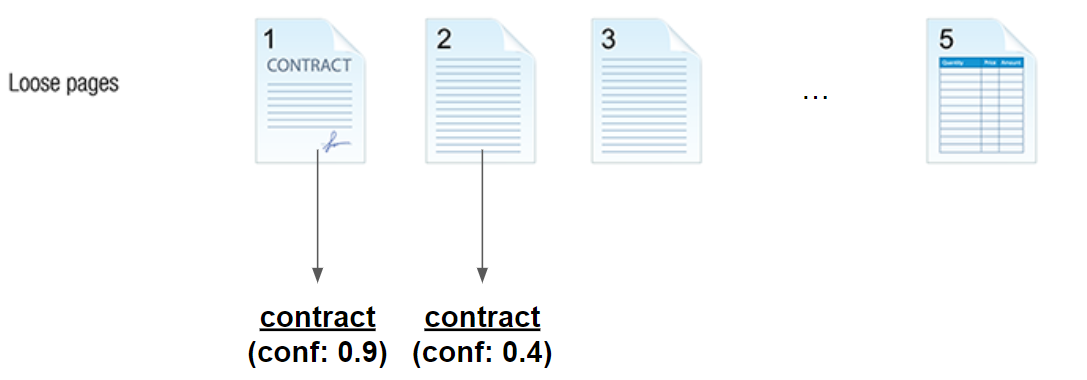

We have some text classifiers which can be used to identify different legal documents:
- Based on `Bert`, taking the first 512 tokens;
- Based on `Longformers`, taking the first 4096 tokens, but being much slower;


`We have more than 150 document classification models for both Longformer and Sentence Bert`

### Using Sentence Bert
Check the Classification notebook to see Legal Longformers in action. By now we will stick with the 512 tokens Bert-base ones.

In [ ]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
  
embeddings = nlp.BertSentenceEmbeddings.pretrained("sent_bert_base_cased", "en")\
    .setInputCols("document")\
    .setOutputCol("sentence_embeddings")
    
doc_classifier = legal.ClassifierDLModel.pretrained("legclf_credit_agreement_bert", "en", "legal/models")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("category")
    
nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler, 
    embeddings,
    doc_classifier])

sent_bert_base_cased download started this may take some time.
Approximate size to download 389.1 MB
[OK!]
legclf_credit_agreement_bert download started this may take some time.
[OK!]


#### Using fit / transform (all Spark Cluster nodes)

In [ ]:
df = spark.createDataFrame([[ pages[0] ]]).toDF("text")
model = nlp_pipeline.fit(df)
result = model.transform(df)

In [ ]:
result.select('category.result').show()

+------------------+
|            result|
+------------------+
|[credit-agreement]|
+------------------+



#### Using Light Pipeline (only driver, quicker but not scalable for big amounts of documents)

In [ ]:
import json

lp = nlp.LightPipeline(model)
json_res = lp.annotate( pages[0] )
print(json_res['category'])

['credit-agreement']


### Are you curious of what would happen with other pages❓

In [ ]:
json_res = lp.annotate( [ pages[0], pages[1], pages[5], pages[9]] )
print(json.dumps(json_res, indent=4))

[
    {
        "document": [
            "Exhibit 10.1\n\n                                                                  EXECUTION COPY\n\n                    $225,000,000.00 REVOLVING CREDIT FACILITY\n\n                                CREDIT AGREEMENT\n\n                                  by and among\n\n                             P.H. GLATFELTER COMPANY\n\n                                       and\n\n                    Certain of its Subsidiaries, as Borrowers\n\n                                       and\n\n                       THE BANKS PARTY HERETO, as Lenders\n\n                                       and\n\n             PNC BANK, NATIONAL ASSOCIATION, as Administrative Agent\n\n                                      with\n\n           PNC CAPITAL MARKETS LLC and CITIZENS BANK OF PENNSYLVANIA,\n\n                  as Joint Lead Arrangers and Joint Bookrunners\n\n                                       and\n\n               CITIZENS BANK OF PENNSYLVANIA, as Syndication Agent

Ok our classifiers, which work on the top 512 tokens, say we have a **10K document** by using the first page.

#✔️ 1.4. Paragraph / Section / Items splitting

## TextSplitter
To split by sentences or paragraphs or ...

In most cases:
- paragraphs can be extracted using just `\n\n`.
- sections and items may be delimited by headers and subheaders. We can train DL models to detect them or, if use numeration (if theyu are numerated sections) or other patterns to delimit their boundaries


In [ ]:
example1 = """Exhibit 10.2

Execution Version

INTELLECTUAL PROPERTY AGREEMENT

This INTELLECTUAL PROPERTY AGREEMENT (this "Agreement"), dated as of December 31, 2018 (the "Effective Date") is entered into by and between Armstrong Flooring, Inc., a Delaware corporation ("Seller") and AFI Licensing LLC, a Delaware limited liability company ("Licensing" and together with Seller, "Arizona") and AHF Holding, Inc. (formerly known as Tarzan HoldCo, Inc.), a Delaware corporation ("Buyer") and Armstrong Hardwood Flooring Company, a Tennessee corporation (the "Company" and together with Buyer the "Buyer Entities") (each of Arizona on the one hand and the Buyer Entities on the other hand, a "Party" and collectively, the "Parties").

WHEREAS, Seller and Buyer have entered into that certain Stock Purchase Agreement, dated November 14, 2018 (the "Stock Purchase Agreement"); WHEREAS, pursuant to the..."""

By `\n\n`...

In [ ]:
text_splitter = legal.TextSplitter() \
    .setInputCols(["document"]) \
    .setOutputCol("paragraphs")\
    .setCustomBounds(["\n\n"])\
    .setUseCustomBoundsOnly(True)\
    .setExplodeSentences(True)

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    text_splitter])

sdf = spark.createDataFrame([[ example1 ]]).toDF("text")

fit = nlp_pipeline.fit(sdf)
res = fit.transform(sdf)

res = res.select('paragraphs.result').show()

+--------------------+
|              result|
+--------------------+
|      [Exhibit 10.2]|
| [Execution Version]|
|[INTELLECTUAL PRO...|
|[This INTELLECTUA...|
|[WHEREAS, Seller ...|
+--------------------+



In [ ]:
text_splitter = legal.TextSplitter() \
    .setInputCols(["document"]) \
    .setOutputCol("paragraphs")\
    .setCustomBounds(["\n\n"])\
    .setUseCustomBoundsOnly(True)\
    .setExplodeSentences(True)

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    text_splitter])

sdf = spark.createDataFrame([[ example1 ]]).toDF("text")

fit = nlp_pipeline.fit(sdf)
res = fit.transform(sdf)

res = res.select('paragraphs.result').show()

+--------------------+
|              result|
+--------------------+
|      [Exhibit 10.2]|
| [Execution Version]|
|[INTELLECTUAL PRO...|
|[This INTELLECTUA...|
|[WHEREAS, Seller ...|
+--------------------+



By other regular expressions ...

In [ ]:
example2 = """
4. GRANT OF KNOW-HOW LICENSE 
4.1 Arizona Know-How Grant. Subject to the terms and conditions of this Agreement, Arizona hereby grants to the Company a perpetual, non- exclusive, royalty-free license in, to and under the Arizona Licensed Know-How for use in the Company Field throughout the world. 
4.2 Company Know-How Grant. Subject to the terms and conditions of this Agreement, the Company hereby grants to Seller a perpetual, non- exclusive, royalty-free license in, to and under the Company Licensed Know-How for use in the Arizona Field throughout the world. 
5. GRANT OF PATENT LICENSE 
5.1 Arizona Patent Grant. Subject to the terms and conditions of this Agreement, Arizona hereby grants to the Company a perpetual, non-exclusive, royalty-free license in, to and under the Arizona Licensed Patents for use in the Company Field throughout the world.
"""

In [ ]:
text_splitter = legal.TextSplitter() \
    .setInputCols(["document"]) \
    .setOutputCol("paragraphs")\
    .setCustomBounds(["\n\d\.?\d? "])\
    .setUseCustomBoundsOnly(True)\
    .setExplodeSentences(True)

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    text_splitter])

sdf = spark.createDataFrame([[ example2 ]]).toDF("text")

fit = nlp_pipeline.fit(sdf)
res = fit.transform(sdf)

res = res.select('paragraphs.result').show()

+--------------------+
|              result|
+--------------------+
|[GRANT OF KNOW-HO...|
|[Arizona Know-How...|
|[Company Know-How...|
|[GRANT OF PATENT ...|
|[Arizona Patent G...|
+--------------------+



BE CAREFUL. If you use a pattern to split and you want it to be included, use `setCustomBoundsStrategy` to `prepend` (goes as the first part of the next section) or `append` (goes as a last part of the previous section)

In [ ]:
text_splitter = legal.TextSplitter() \
    .setInputCols(["document"]) \
    .setOutputCol("paragraphs")\
    .setCustomBounds(["\n\d\.?\d? "])\
    .setCustomBoundsStrategy('prepend')\
    .setUseCustomBoundsOnly(True)\
    .setExplodeSentences(True)

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    text_splitter])

sdf = spark.createDataFrame([[ example2 ]]).toDF("text")

fit = nlp_pipeline.fit(sdf)
res = fit.transform(sdf)

res = res.select('paragraphs.result').show()

+--------------------+
|              result|
+--------------------+
|[4. GRANT OF KNOW...|
|[4.1 Arizona Know...|
|[4.2 Company Know...|
|[5. GRANT OF PATE...|
|[5.1 Arizona Pate...|
+--------------------+



## Using NER and ChunkSentenceSplitter


... using pretrained NER models for `Headers and Subheaders`

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")
        
sentenceDetector = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl","xx")\
        .setInputCols(["document"])\
        .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
        .setInputCols(["sentence"])\
        .setOutputCol("token")

embeddings = nlp.RoBertaEmbeddings.pretrained("roberta_embeddings_legal_roberta_base","en") \
        .setInputCols(["sentence", "token"]) \
        .setOutputCol("embeddings")

ner_model = legal.NerModel.pretrained("legner_headers", "en", "legal/models")\
        .setInputCols(["sentence", "token", "embeddings"])\
        .setOutputCol("ner")

ner_converter = nlp.NerConverter()\
        .setInputCols(["sentence","token","ner"])\
        .setOutputCol("ner_chunk")

nlp_pipeline = nlp.Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        embeddings,
        ner_model,
        ner_converter])

sentence_detector_dl download started this may take some time.
Approximate size to download 514.9 KB
[OK!]
roberta_embeddings_legal_roberta_base download started this may take some time.
Approximate size to download 447.2 MB
[OK!]
legner_headers download started this may take some time.
[OK!]


In [ ]:
text = """AGREEMENT

NOW, THEREFORE, for good and valuable consideration, and in consideration of the mutual covenants and conditions herein contained, the Parties agree as follows:

2. Definitions. For purposes of this Agreement, the following terms have the meanings ascribed thereto in this Section 1. 2. Appointment as Reseller.

2.1 Appointment. The Company hereby [***]. Allscripts may also disclose Company's pricing information relating to its Merchant Processing Services and facilitate procurement of Merchant Processing Services on behalf of Sublicensed Customers, including, without limitation by references to such pricing information and Merchant Processing Services in Customer Agreements. 6

2.2 Customer Agreements.

a) Subscriptions. Allscripts and its Affiliates may sell Subscriptions for terms no less than one year and no greater than four (4) years on a subscription basis to Persons who subsequently execute a Customer Agreement, provided that Allscripts may enter into Customer Agreements with terms longer than four (4) years with large organizations, provided that Phreesia consents in each instance in writing in advance, which consent will not be unreasonably withheld."""


In [ ]:
sdf = spark.createDataFrame([[ text ]]).toDF("text")

fit = nlp_pipeline.fit(sdf)

lp = nlp.LightPipeline(fit)

In [ ]:
res = lp.fullAnnotate(text)

In [ ]:
from johnsnowlabs import viz

ner_viz = viz.NerVisualizer()

ner_viz.display(res[0], label_col='ner_chunk')

In [ ]:
ner_res = res[0]['ner_chunk'] # Document 0

sections = []
for ann in ner_res:
  sections.append( (ann.begin, ann.end) )
sections

[(0, 8), (173, 186), (295, 320), (324, 338), (698, 720), (724, 739)]

In [ ]:
section_texts = []
last_section = 0
last_section_name = ""
for s in sections:
  t = last_section_name + text[last_section:s[0]]
  if t != '':
    section_texts.append(t)  
  last_section = s[1]+1
  last_section_name = text[s[0]:s[1]+1]
section_texts.append(last_section_name + text[last_section:s[0]])  

In [ ]:
OKGREEN = '\033[92m'
ENDC = '\033[0m'

In [ ]:
for t in section_texts:
  print(f"{OKGREEN}SECTION:{ENDC}\n{t}")

SECTION:
AGREEMENT

NOW, THEREFORE, for good and valuable consideration, and in consideration of the mutual covenants and conditions herein contained, the Parties agree as follows:


SECTION:
2. Definitions. For purposes of this Agreement, the following terms have the meanings ascribed thereto in this Section 1. 
SECTION:
2. Appointment as Reseller.


SECTION:
2.1 Appointment. The Company hereby [***]. Allscripts may also disclose Company's pricing information relating to its Merchant Processing Services and facilitate procurement of Merchant Processing Services on behalf of Sublicensed Customers, including, without limitation by references to such pricing information and Merchant Processing Services in Customer Agreements. 6


SECTION:
2.2 Customer Agreements.


SECTION:
a) Subscriptions


... or automatically using ChunkSentenceSpliting...

In [ ]:
chunkSentenceSplitter = legal.ChunkSentenceSplitter()\
    .setInputCols("document","ner_chunk")\
    .setOutputCol("paragraphs")\
    .setGroupBySentences(False)

    
nlp_pipeline = nlp.Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        embeddings,
        ner_model,
        ner_converter,
        chunkSentenceSplitter])


paragraphs = nlp_pipeline.fit(sdf).transform(sdf)

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
result_df = paragraphs.selectExpr("explode(paragraphs) as result").selectExpr("result.result","result.metadata.entity").toPandas()
result_df.head()

result  \
0                                                                                                                                                                                                         AGREEMENT\n\nNOW, THEREFORE, for good and valuable consideration, and in consideration of the mutual covenants and conditions herein contained, the Parties agree as follows:\n\n   
1                                                                                                                                                                                                                                                                2. Definitions. For purposes of this Agreement, the following terms have the meanings ascribed thereto in this Section 1.    
2                                                                                                                                                                                                                                                                                                                                                           2. Appointment as Reseller.\n\n   
3  2.1 Appointment. The Company hereby [***]. Allscripts may also disclose Company's pricing information relating to its Merchant Processing Services and facilitate procurement of Merchant Processing Services on behalf of Sublicensed Customers, including, without limitation by references to such pricing information and Merchant Processing Services in Customer Agreements. 6\n\n   
4                                                                                                                                                                                                                                                                                                                                                              2.2 Customer Agreements.\n\n   

      entity  
0     HEADER  
1     HEADER  
2     HEADER  
3  SUBHEADER  
4  SUBHEADER

## Pretrained Pipeline for Section Splitting
This is just section splitting using NER with ContextualParser. 

So just use it to get some headers and subheaders from legal document like `1. Items` or `2.2. Disclousers ` etc.

You can check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/legal-nlp/05.6.Contextual_Parser_Rule_Based_NER.ipynb) to learn how ContextualParser works.

In [ ]:
legal_pipeline = nlp.PretrainedPipeline("legpipe_header_subheader", "en", "legal/models")

legpipe_header_subheader download started this may take some time.
Approx size to download 23 KB
[OK!]


In [ ]:
legal_pipeline.model.stages

[DocumentAssembler_b472a95d49de,
 REGEX_TOKENIZER_22dc8c206996,
 CONTEXTUAL-PARSER_d7bc800f45ce,
 CONTEXTUAL-PARSER_3c3c655d79ad,
 MERGE_981702c8024d]

This pre-trained Pipeline includes two ContextualParser. The first one extracts the `HEADER` section and the second one extracts the `SUBHEADER` section.

In [ ]:
text = ["""2. DEFINITION. 

For purposes of this Agreement, the following terms have the meanings ascribed thereto in this Section 1 and 2 Appointment as Reseller.

2.1 Appointment. 

The Company hereby [***]. Allscripts may also disclose Company's pricing information relating to its Merchant Processing Services and facilitate procurement of Merchant Processing Services on behalf of Sublicensed Customers, including, without limitation by references to such pricing information and Merchant Processing Services in Customer Agreements. 6

2.2 Customer Agreements."""]

result = legal_pipeline.fullAnnotate(text)[0]

result

{'document': [Annotation(document, 0, 553, 2. DEFINITION. 
  
  For purposes of this Agreement, the following terms have the meanings ascribed thereto in this Section 1 and 2 Appointment as Reseller.
  
  2.1 Appointment. 
  
  The Company hereby [***]. Allscripts may also disclose Company's pricing information relating to its Merchant Processing Services and facilitate procurement of Merchant Processing Services on behalf of Sublicensed Customers, including, without limitation by references to such pricing information and Merchant Processing Services in Customer Agreements. 6
  
  2.2 Customer Agreements., {}, [])],
 'merged_chunk': [Annotation(chunk, 0, 12, 2. DEFINITION, {'tokenIndex': '0', 'entity': 'HEADER', 'field': 'HEADER', 'chunk': '0', 'normalized': '', 'sentence': '0', 'confidenceValue': '0.50'}, []),
  Annotation(chunk, 154, 168, 2.1 Appointment, {'tokenIndex': '28', 'entity': 'SUBHEADER', 'field': 'SUBHEADER', 'chunk': '1', 'normalized': '', 'sentence': '0', 'confidenceVal

In [ ]:
import pandas as pd

chunks = []
entities = []
begin = []
end = []

for n in result['merged_chunk']:
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    
df = pd.DataFrame({'chunks':chunks, 
                   'begin': begin, 
                   'end':end, 
                   'entities':entities})
df.head(20)

chunks  begin  end   entities
0            2. DEFINITION      0   12     HEADER
1          2.1 Appointment    154  168  SUBHEADER
2  2.2 Customer Agreements    530  552  SUBHEADER

In [ ]:
# Visualize outputs

visualiser = nlp.viz.NerVisualizer()

visualiser.display(result, label_col='merged_chunk', document_col='document')

## Contextual Parser for SUBHEADER

#✔️ 1.5. Paragraph Classification and the consequences of splitting

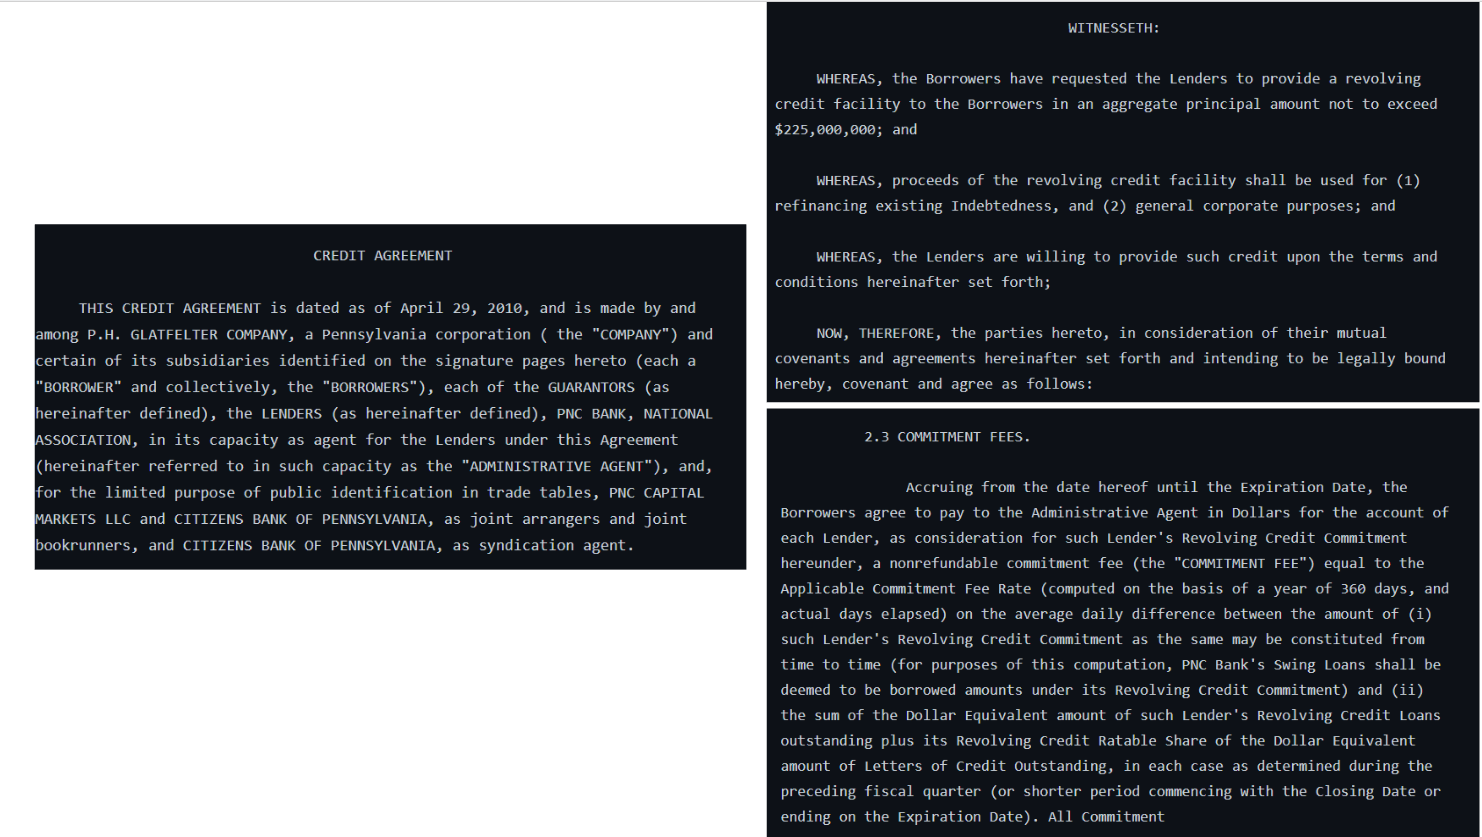


In Legal NLP we have more than 350 classifiers which you can use to detect specific clauses in your documents. You can find them in Models Hub, where they all end with `_clause`

```
...
- legclf_indemnification_clause
- legclf_insolvency_clause
- legclf_whereas_clause
- legclf_indebtedness_clause
- legclf_in_witness_whereof_clause
- legclf_illegality_clause
- legclf_indebtedness_clause
- legclf_guarantee_clause
- legclf_increased_costs_clause
- legclf_insurance_clause
- legclf_intellectual_property_clause
- legclf_interest_clause
- legclf_jurisdiction_clause
- legclf_letters_of_credit_clause
- legclf_liability_clause
...
```
All of these models are Binary Classifiers, which means they will return True or False, or better to say ,the name of the class (for example, `whereas`) if the class `whereas` is found, or `other` if it's not a `wheras` clause, but something else.

CLARIFICATION: We did not want to return `True` or `False` because these models can all be stuck one after another, so in case a clause triggers some classes at the same time (clauses are very often not disjoint) we could be getting several `True`, which is less informative than retrieving directly the type of the classes detected `interest` and `increased_costs` for example.


## Example of how splitting affects paragraph classification

In [ ]:
document_assembler = nlp.DocumentAssembler() \
        .setInputCol("text") \
        .setOutputCol("document")

text_splitter = legal.TextSplitter() \
    .setInputCols(["document"]) \
    .setOutputCol("pages")\
    .setCustomBounds(["\n+\s*[0-9-ivx]+\s*\n+"])\
    .setUseCustomBoundsOnly(True)\
    .setExplodeSentences(True)

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    text_splitter])

In [ ]:
sdf = spark.createDataFrame([[ credit_agreement ]]).toDF("text")

fit = nlp_pipeline.fit(sdf)

lp = nlp.LightPipeline(fit)

res = lp.annotate(credit_agreement)
pages = res['pages']
pages = [p for p in pages if p.strip() != ''] # We remove empty pages

In [ ]:
candidates = [[pages[0]], [pages[5]], [pages[8]], [pages[9]]]

In [ ]:
document_assembler = nlp.DocumentAssembler() \
      .setInputCol("text") \
      .setOutputCol("document")

embeddings = nlp.BertSentenceEmbeddings.pretrained("sent_bert_base_cased", "en") \
      .setInputCols("document") \
      .setOutputCol("sentence_embeddings")

doc_classifier = legal.ClassifierDLModel.pretrained('legclf_whereas_clause', "en", "legal/models")\
      .setInputCols(["sentence_embeddings"])\
      .setOutputCol("category")

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler, 
    embeddings,
    doc_classifier])

sent_bert_base_cased download started this may take some time.
Approximate size to download 389.1 MB
[OK!]
legclf_whereas_clause download started this may take some time.
[OK!]


In [ ]:
df = spark.createDataFrame(candidates).toDF("text")

model = nlp_pipeline.fit(df)

result = model.transform(df)
result.select('category.result').show()

+---------+
|   result|
+---------+
|  [other]|
|  [other]|
|[whereas]|
|  [other]|
+---------+



we have some whereas information in `page[8]`!

In [ ]:
print(pages[8])

CREDIT AGREEMENT

     THIS CREDIT AGREEMENT is dated as of April 29, 2010, and is made by and
among P.H. GLATFELTER COMPANY, a Pennsylvania corporation ( the "COMPANY") and
certain of its subsidiaries identified on the signature pages hereto (each a
"BORROWER" and collectively, the "BORROWERS"), each of the GUARANTORS (as
hereinafter defined), the LENDERS (as hereinafter defined), PNC BANK, NATIONAL
ASSOCIATION, in its capacity as agent for the Lenders under this Agreement
(hereinafter referred to in such capacity as the "ADMINISTRATIVE AGENT"), and,
for the limited purpose of public identification in trade tables, PNC CAPITAL
MARKETS LLC and CITIZENS BANK OF PENNSYLVANIA, as joint arrangers and joint
bookrunners, and CITIZENS BANK OF PENNSYLVANIA, as syndication agent.

                                   WITNESSETH:

     WHEREAS, the Borrowers have requested the Lenders to provide a revolving
credit facility to the Borrowers in an aggregate principal amount not to exceed
$225,000,00

But what if the splitting would have been different?

In [ ]:
text = """
-vii-



                         LIST OF SCHEDULES AND EXHIBITS

SCHEDULES
SCHEDULE 1.1(A)   - PRICING GRID
SCHEDULE 1.1(B)   - COMMITMENTS OF BANKS AND ADDRESSES FOR NOTICES
SCHEDULE 1.1(E)   - EXISTING LETTERS OF CREDIT
SCHEDULE 1.1(M)   - MATERIAL SUBSIDIARIES
SCHEDULE 1.1(P)   - PERMITTED LIENS
SCHEDULE 5.1.1    - DOMESTIC QUALIFICATIONS TO DO BUSINESS
SCHEDULE 5.1.2    - SUBSIDIARIES
SCHEDULE 5.1.6    - LITIGATION
SCHEDULE 5.1.12   - CONSENTS AND APPROVALS
SCHEDULE 5.1.14   - PATENTS, TRADEMARKS, COPYRIGHTS, LICENSES, ETC.
SCHEDULE 7.2.1    - PERMITTED INDEBTEDNESS
SCHEDULE 7.2.4    - EXISTING INVESTMENTS

EXHIBITS
EXHIBIT 1.1(A)    - ASSIGNMENT AND ASSUMPTION AGREEMENT
EXHIBIT 1.1(B)    - BORROWER JOINDER
EXHIBIT 1.1(G)(1) - GUARANTOR JOINDER
EXHIBIT 1.1(G)(2) - GUARANTY AGREEMENT
EXHIBIT 1.1(R)    - REVOLVING CREDIT NOTE
EXHIBIT 1.1(S)    - SWING LOAN NOTE
EXHIBIT 2.4       - LOAN REQUEST
EXHIBIT 6.1.4     - OPINION OF COUNSEL
EXHIBIT 7.2.6     - ACQUISITION COMPLIANCE CERTIFICATE
EXHIBIT 7.3.3     - QUARTERLY COMPLIANCE CERTIFICATE


                                     -viii-



                                CREDIT AGREEMENT

     THIS CREDIT AGREEMENT is dated as of April 29, 2010, and is made by and
among P.H. GLATFELTER COMPANY, a Pennsylvania corporation ( the "COMPANY") and
certain of its subsidiaries identified on the signature pages hereto (each a
"BORROWER" and collectively, the "BORROWERS"), each of the GUARANTORS (as
hereinafter defined), the LENDERS (as hereinafter defined), PNC BANK, NATIONAL
ASSOCIATION, in its capacity as agent for the Lenders under this Agreement
(hereinafter referred to in such capacity as the "ADMINISTRATIVE AGENT"), and,
for the limited purpose of public identification in trade tables, PNC CAPITAL
MARKETS LLC and CITIZENS BANK OF PENNSYLVANIA, as joint arrangers and joint
bookrunners, and CITIZENS BANK OF PENNSYLVANIA, as syndication agent.

                                   WITNESSETH:

     WHEREAS, the Borrowers have requested the Lenders to provide a revolving
credit facility to the Borrowers in an aggregate principal amount not to exceed
$225,000,000; and

     WHEREAS, proceeds of the revolving credit facility shall be used for (1)
refinancing existing Indebtedness, and (2) general corporate purposes; and

     WHEREAS, the Lenders are willing to provide such credit upon the terms and
conditions hereinafter set forth;

     NOW, THEREFORE, the parties hereto, in consideration of their mutual
covenants and agreements hereinafter set forth and intending to be legally bound
hereby, covenant and agree as follows:"""

In [ ]:
df = spark.createDataFrame([[text]]).toDF("text")

model = nlp_pipeline.fit(df)

result = model.transform(df)
result.select('category.result').show()

+-------+
| result|
+-------+
|[other]|
+-------+



#📜 Conclusions

Splitting affects directly the quality of the predictions. This is because of two factors:
- 1) Predicting much text at the same time usually adds too much information, and specific sections may be deluted in the overall context;
- 2) Also token size restrictions may have happened!